In [1]:
import os

# 切换到上层文件夹
os.chdir("..")

# 验证
print("当前工作目录:", os.getcwd())

当前工作目录: /home/sunshine8641/Code/OOD


In [2]:
import os
import torch
import torch.nn as nn
from accelerate import Accelerator
from data_utils.build_dataset import build_id_dataloaders,build_ood_dataloaders,build_jigsaw_dataloaders
from methods import forward_base,calculate_layer_norm
from models import get_model,ParametricBReLU,ParametricBoundedLeakyReLU,BoundedPReLU
from utils import get_args, merge_args_with_config, load_config, accuracy, MetersGroup,\
format_meters_log
from safetensors.torch import load_file
from collections import OrderedDict
from metrics import  *
from  methods import *
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from train.train_utils import load_clean_model_state
from eval import exp_base,  initialize_experiment
from data_utils.transforms import get_ood_transform,get_id_transform


from utils import *

/home/sunshine8641/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sunshine8641/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/sunshine8641/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
args = argparse.Namespace()
args.config="configs/base_imagenet_wideresnet.yaml"# get_args()
if args.config:
    cfg = load_config(args.config)
    config = merge_args_with_config(args, cfg)
else:
    config = vars(args)  # 如果没有配置文件，直接用args
print(config)

{'exp_name': 'wideresnet_imagenet_relu', 'id_dataset': {'name': 'imagenet', 'root': '/home/sunshine8641/Code/Data/'}, 'ood_dataset': {'name': 'svhn', 'root': '/home/sunshine8641/Code/Data/'}, 'top_5': False, 'model': {'type': 'wrn16_8', 'pretrained': False, 'num_classes': 100, 'activation': 'relu', 'last_block_activation': 'relu'}, 'num_classes': 100, 'test_model': 'base_best', 'start_epoch': 0, 'epochs': 200, 'lr': 0.1, 'min_lr': 0, 'weight_decay': 5e-05, 'mixed_precision': 'fp16', 'batch_size': 32, 'gradient_accumulation_steps': 1, 'num_workers': 4, 'momentum': 0.9, 'optimizer': 'SGD', 'scheduler': 'cosine', 'step_gamma': 0.1, 'step_size': 30, 'train_method': 'base', 'use_swa': False, 'swa_window': 40, 'swa_start': 0, 'label_smooth': False, 'smoothing': 0.1, 'num_blocks': 6, 'sblock': 0, 'log': {'log_dir': './logs', 'use_loguru': True}, 'odin_temperature': 1000.0, 'odin_magnitude': 0.01, 'bats_lam': 3.25, 'laps_lam': 1.5, 'laps_m': 13, 'laps_n': 0, 'config': 'configs/base_imagenet_wi

In [4]:
config["mixed_precision"]='no'
config['batch_size']=32

accelerator,model,criterion,train_meters,test_meters,top_k,id_train_loader,id_test_loader,id_val_loader,ood_loader=initialize_experiment(config)


[Test] Loading OOD Dataloader for svhn...
Using downloaded and verified file: /home/sunshine8641/Code/Data/test_32x32.mat
cuda


<h1 style="color:green; text-shadow: 0 0 10px #ff00ff, 0 0 10px #ff00ff">
  Prepare Experiment
</h1>

In [5]:
n_iter=len(id_test_loader)
tr=get_id_transform(cfg['id_dataset']['name'])
for t in tr[0].transforms:
    if isinstance(t, transforms.Normalize):
        print("Mean:", t.mean)
        mean=t.mean
        print("Std:", t.std)
        std=t.std

Mean: [0.485, 0.456, 0.406]
Std: [0.229, 0.224, 0.225]


ID Train Batch: x.shape=torch.Size([32, 3, 224, 224]), y.shape=torch.Size([32])
图像已保存到: Figs/x.png


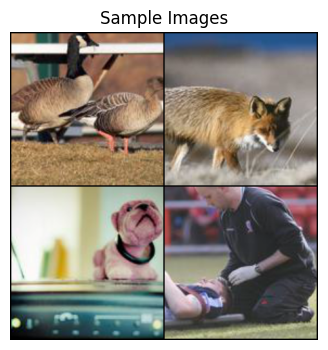

In [6]:
for batch in id_val_loader:
    x, y = batch
    print(f"ID Train Batch: x.shape={x.shape}, y.shape={y.shape}")
    break
show_images(x, y,mean,std, n=4)

In [7]:
model.eval()
test_meters.reset()
with torch.no_grad():
    for inputs, targets in id_test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        topk_acc = accuracy(outputs, targets, topk=top_k)
        acc_dict = {f"Acc@{k}": acc.item() for k, acc in zip(top_k, topk_acc)}
        acc_dict["Loss"] = loss.item()
        test_meters.update(acc_dict, n=targets.size(0))
log_str = format_meters_log(0, test_meters.meters,0, None, prefix="Val Epoch")
print(log_str)

Val Epoch 0 | Loss: 0.9703 | Acc@1: 77.23% | Time: 0.00


In [7]:
methods=[l2norm,lambda x: adaptive_topk_channel_weight(x, k_min=0.1, k_max=0.25,alpha =0,eps=1e-8)]  


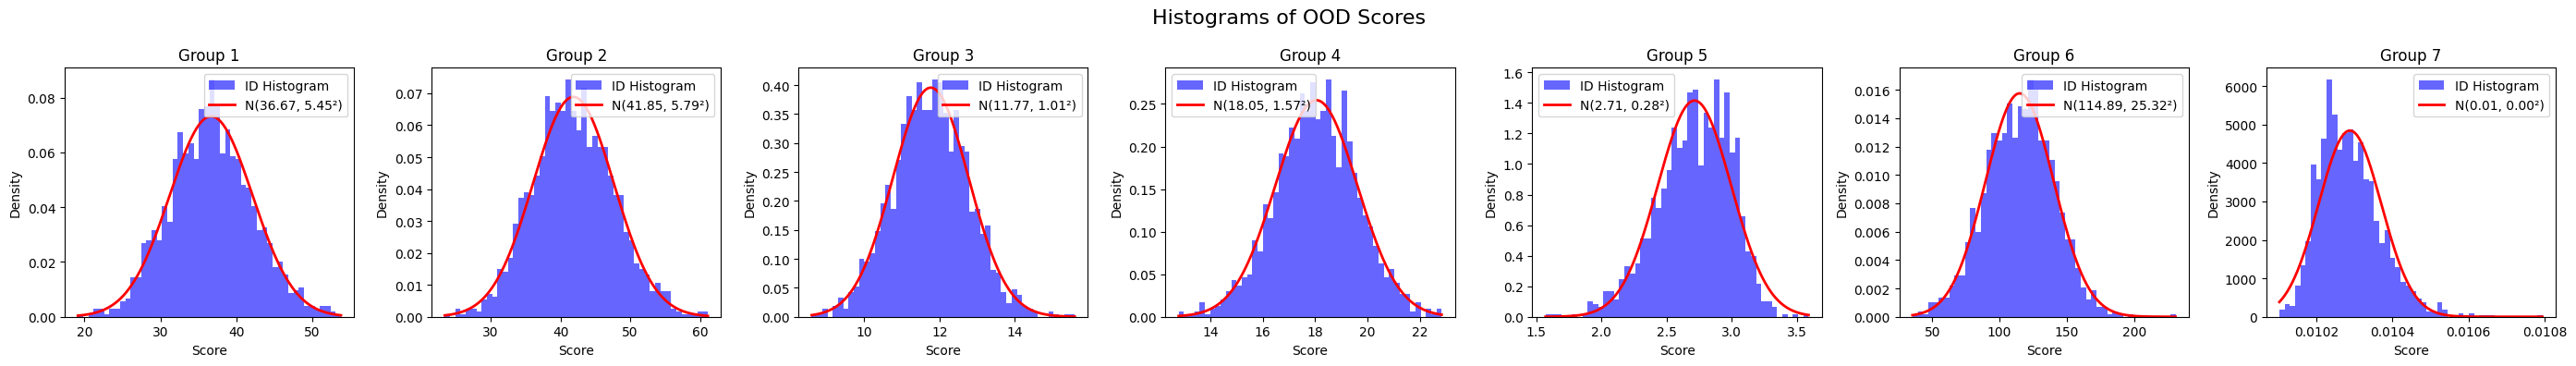

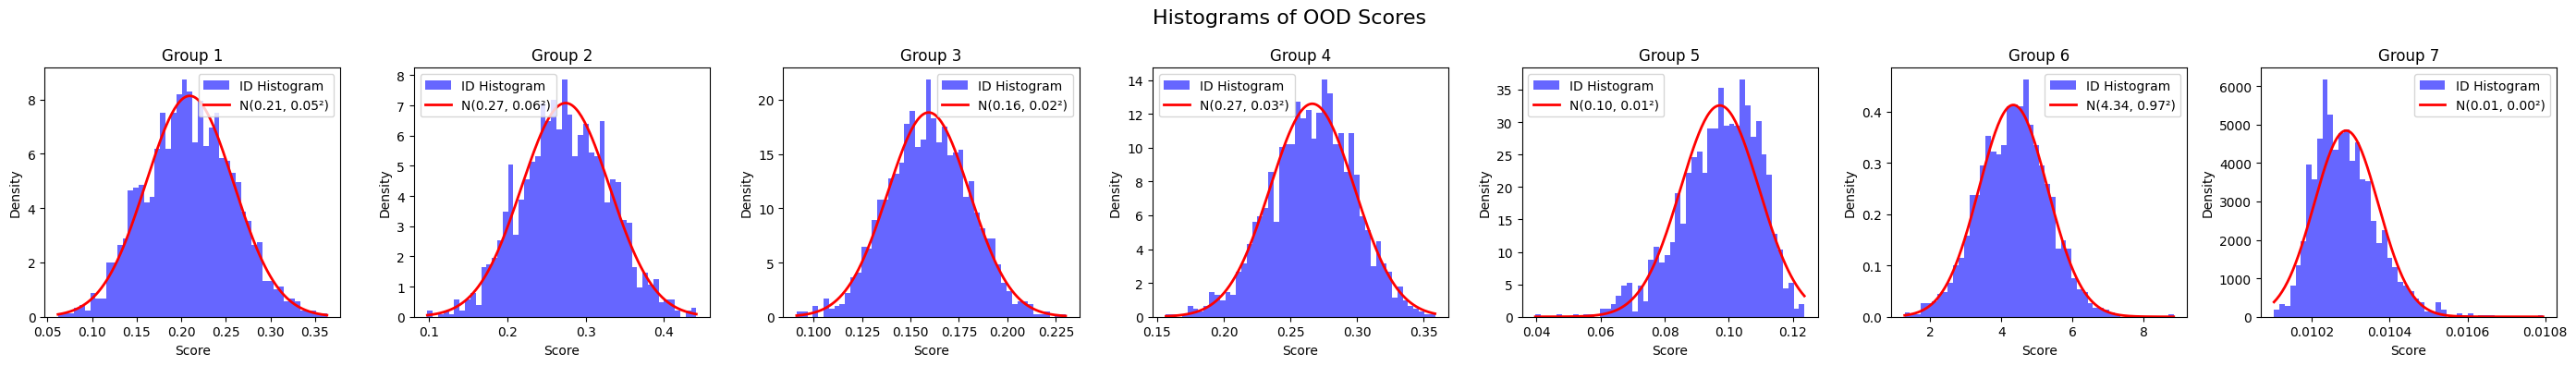

[array([5.26073992e+01, 6.06016173e+01, 1.52205879e+01, 2.27556876e+01,
       3.44203078e+00, 1.93104368e+02, 1.06574913e-02]), array([0.35307752, 0.44038176, 0.2233531 , 0.35225256, 0.12342906,
       7.1809421 , 0.01065749])]
[array([2.48285628e+01, 2.89447888e+01, 9.42525180e+00, 1.42807665e+01,
       1.96974556e+00, 5.41872216e+01, 1.01380620e-02]), array([0.10267556, 0.14772013, 0.10802137, 0.18781364, 0.06463233,
       1.98645014, 0.01013806])]


In [8]:
QE=[]
QS=[]
for norm_func in methods:
    id_norms_all=get_all_activation_strength(model, id_val_loader, norm_func,"react" ,"odin", accelerator, n_iter, config)
    means, stds,qs,qe=compute_id_statistics(id_norms_all,qs=1,qe=99.9)
    QE.append(qe)
    QS.append(qs)
    plot_histograms_one(id_norms_all,means,stds, bins=50, title="Histograms of OOD Scores")
print(QE)
print(QS)

<h1 style="color:green; text-shadow: 0 0 10px #ff00ff, 0 0 10px #ff00ff">
  OOD Dataset1: Textures
</h1>

[Test] Loading OOD Dataloader for textures...
cuda
ID Train Batch: x.shape=torch.Size([32, 3, 224, 224])
图像已保存到: Figs/x.png


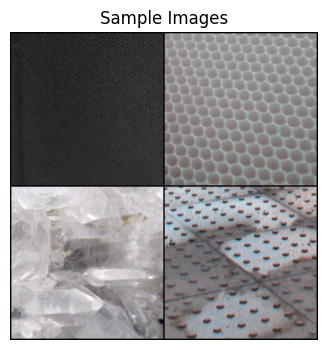

In [9]:
cfg["ood_dataset"]["name"]="textures"
accelerator,model,criterion,train_meters,test_meters,top_k,id_train_loader,id_test_loader,id_val_loader,ood_loader=initialize_experiment(config)
for batch in ood_loader:
    x, y = batch
    print(f"ID Train Batch: x.shape={x.shape}")
    break
show_images(x, y,mean,std, n=4)

<function l2norm at 0x7d763a76f490>


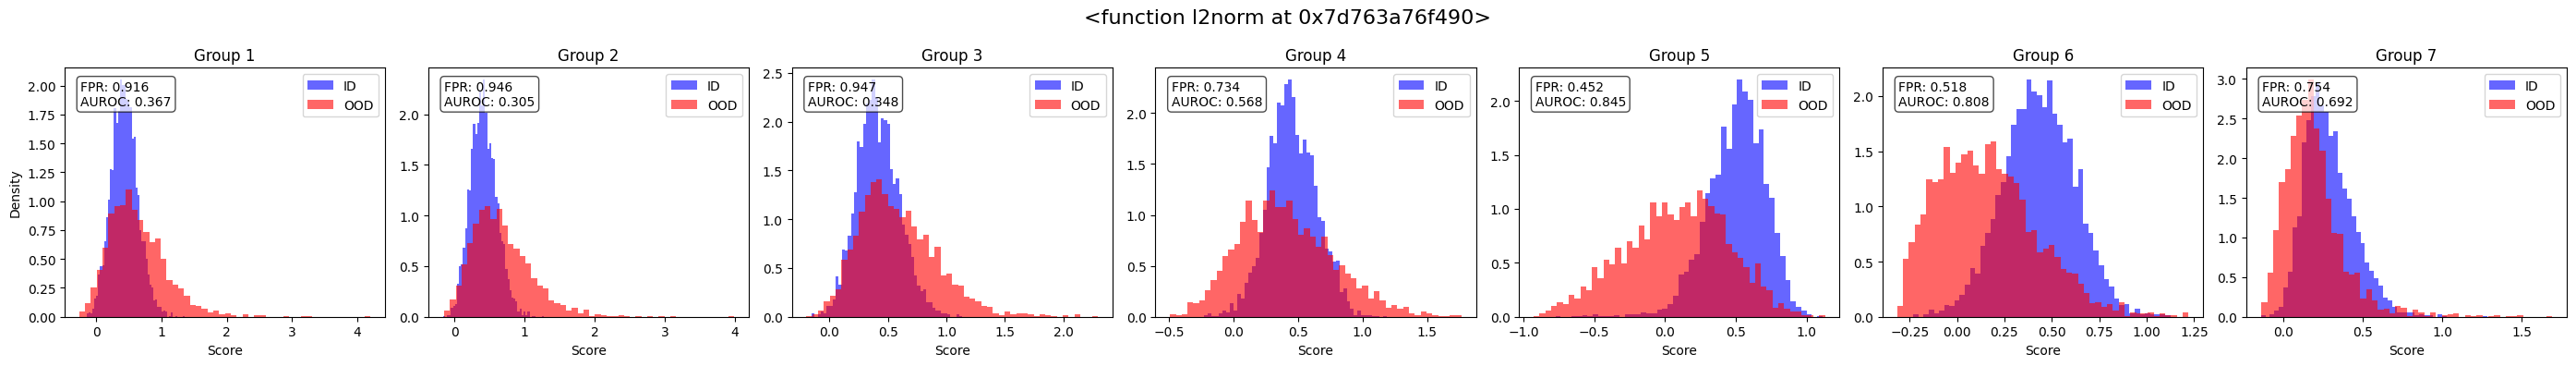

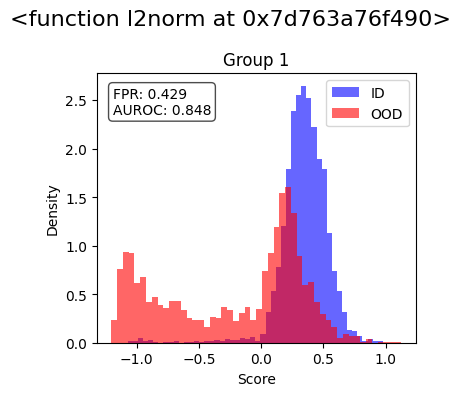

In [10]:
i=0
print(methods[i])
id_norms_all=get_all_activation_strength(model, id_test_loader,methods[i],"react" ,"odin", accelerator, n_iter, config)
ood_norms_all=get_all_activation_strength(model, ood_loader,methods[i],"react" ,"odin", accelerator, n_iter, config)
scores_in_all_standard=compute_standard_score(id_norms_all, QS[i], QE[i]-QS[i])
scores_out_all_standard=compute_standard_score(ood_norms_all,  QS[i], QE[i]-QS[i])
plot_histograms(np.copy(scores_in_all_standard), np.copy(scores_out_all_standard), bins=50, title=str(methods[i]))
scores_main_out=scores_out_all_standard[[5,6],:]
scores_other_out=scores_out_all_standard[[0,1,2,3,4],:]
scores_main_in=scores_in_all_standard[[5,6],:]
scores_other_in=scores_in_all_standard[[0,1,2,3,4],:]
a,delta_score_in=fuse_norm(scores_main_in,scores_other_in)
b,delta_score_out=fuse_norm(scores_main_out,scores_other_out)
plot_histograms(a,b, bins=50, title=str(methods[i]))



<function <lambda> at 0x7d7644d7aa70>


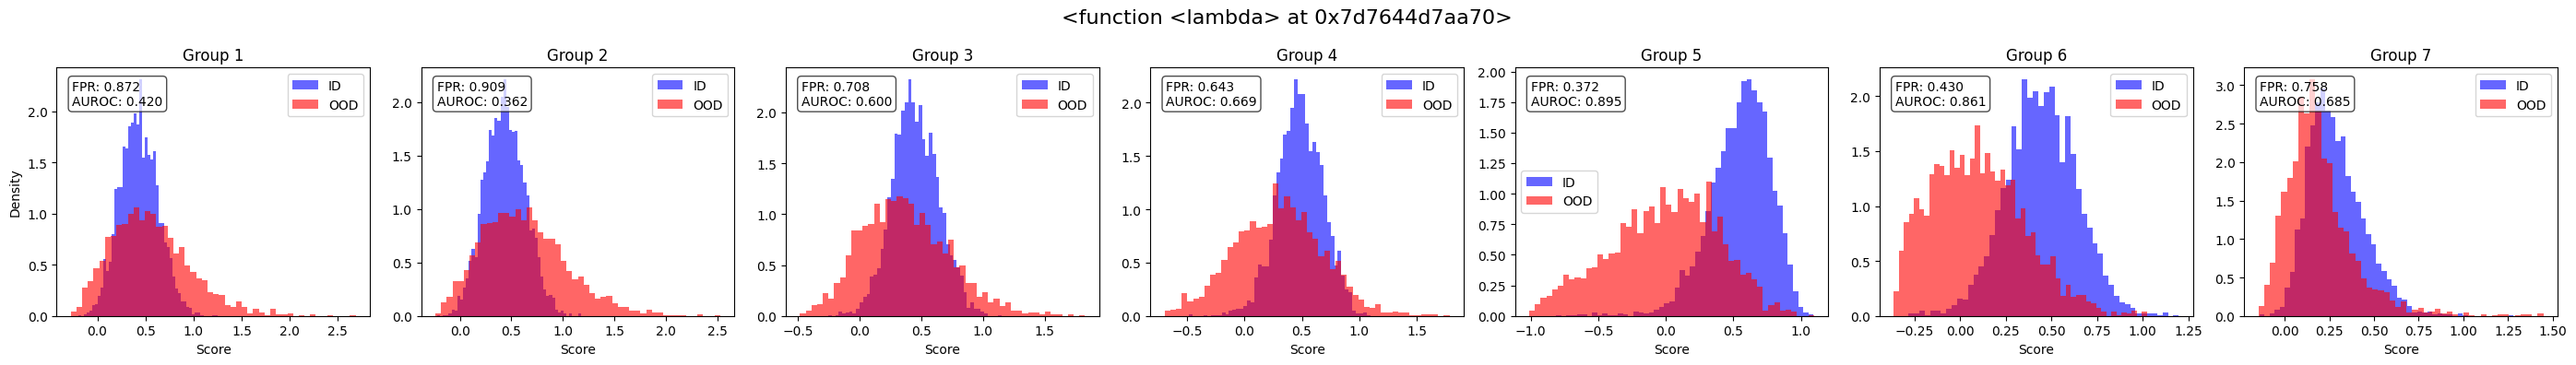

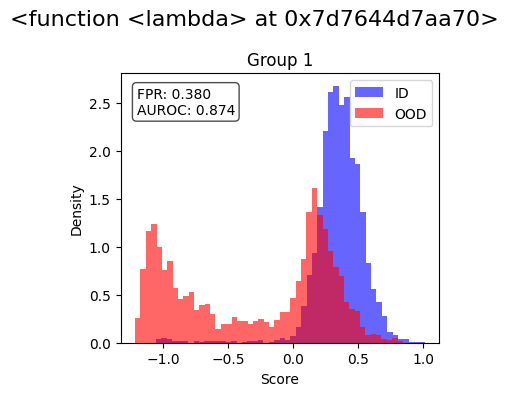

In [11]:
i=1
print(methods[i])
id_norms_all=get_all_activation_strength(model, id_test_loader,methods[i],"react" ,"odin", accelerator, n_iter, config)
ood_norms_all=get_all_activation_strength(model, ood_loader,methods[i],"react" ,"odin", accelerator, n_iter, config)
scores_in_all_standard=compute_standard_score(id_norms_all, QS[i], QE[i]-QS[i])
scores_out_all_standard=compute_standard_score(ood_norms_all,  QS[i], QE[i]-QS[i])
plot_histograms(np.copy(scores_in_all_standard), np.copy(scores_out_all_standard), bins=50, title=str(methods[i]))
scores_main_out=scores_out_all_standard[[5,6],:]
scores_other_out=scores_out_all_standard[[0,1,2,3,4],:]
scores_main_in=scores_in_all_standard[[5,6],:]
scores_other_in=scores_in_all_standard[[0,1,2,3,4],:]
a,delta_score_in=fuse_norm(scores_main_in,scores_other_in)
b,delta_score_out=fuse_norm(scores_main_out,scores_other_out)
plot_histograms(a,b, bins=50, title=str(methods[i]))



<h1 style="color:green; text-shadow: 0 0 10px #ff00ff, 0 0 10px #ff00ff">
  OOD Dataset2: INaturalist
</h1>

[Test] Loading OOD Dataloader for iNaturalist...
/home/sunshine8641/Code/Data/iNaturalist
cuda
ID Train Batch: x.shape=torch.Size([32, 3, 224, 224])
图像已保存到: Figs/x.png


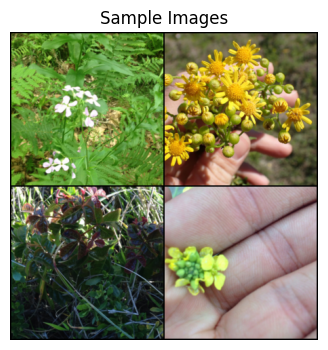

In [12]:
cfg["ood_dataset"]["name"]="iNaturalist"
accelerator,model,criterion,train_meters,test_meters,top_k,id_train_loader,id_test_loader,id_val_loader,ood_loader=initialize_experiment(config)
for batch in ood_loader:
    x, y = batch
    print(f"ID Train Batch: x.shape={x.shape}")
    break
show_images(x, y,mean,std, n=4)

<function l2norm at 0x7d763a76f490>


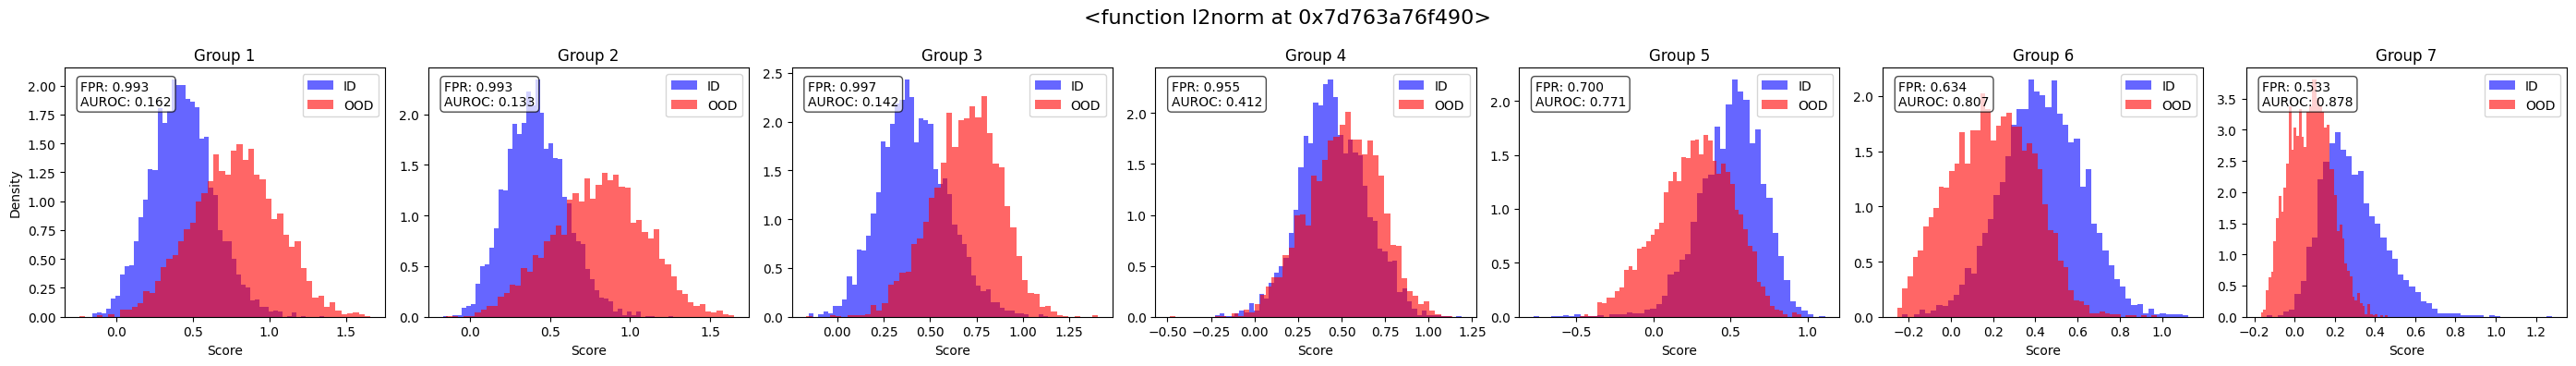

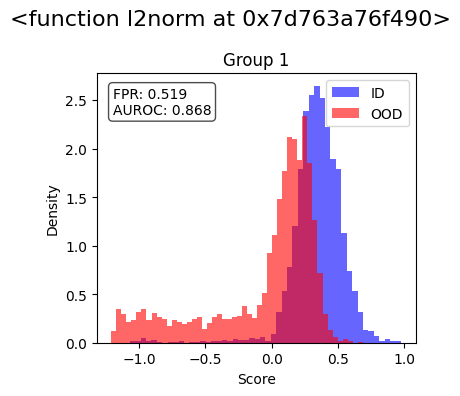

In [14]:
i=0
print(methods[i])
id_norms_all=get_all_activation_strength(model, id_test_loader,methods[i],"react" ,"odin", accelerator, n_iter, config)
ood_norms_all=get_all_activation_strength(model, ood_loader,methods[i],"react" ,"odin", accelerator, n_iter, config)
scores_in_all_standard=compute_standard_score(id_norms_all, QS[i], QE[i]-QS[i])
scores_out_all_standard=compute_standard_score(ood_norms_all,  QS[i], QE[i]-QS[i])
plot_histograms(np.copy(scores_in_all_standard), np.copy(scores_out_all_standard), bins=50, title=str(methods[i]))
scores_main_out=scores_out_all_standard[[5,6],:]
scores_other_out=scores_out_all_standard[[0,1,2,3,4],:]
scores_main_in=scores_in_all_standard[[5,6],:]
scores_other_in=scores_in_all_standard[[0,1,2,3,4],:]
a,delta_score_in=fuse_norm(scores_main_in,scores_other_in)
b,delta_score_out=fuse_norm(scores_main_out,scores_other_out)
plot_histograms(a,b, bins=50, title=str(methods[i]))



<function <lambda> at 0x7d7644d7aa70>


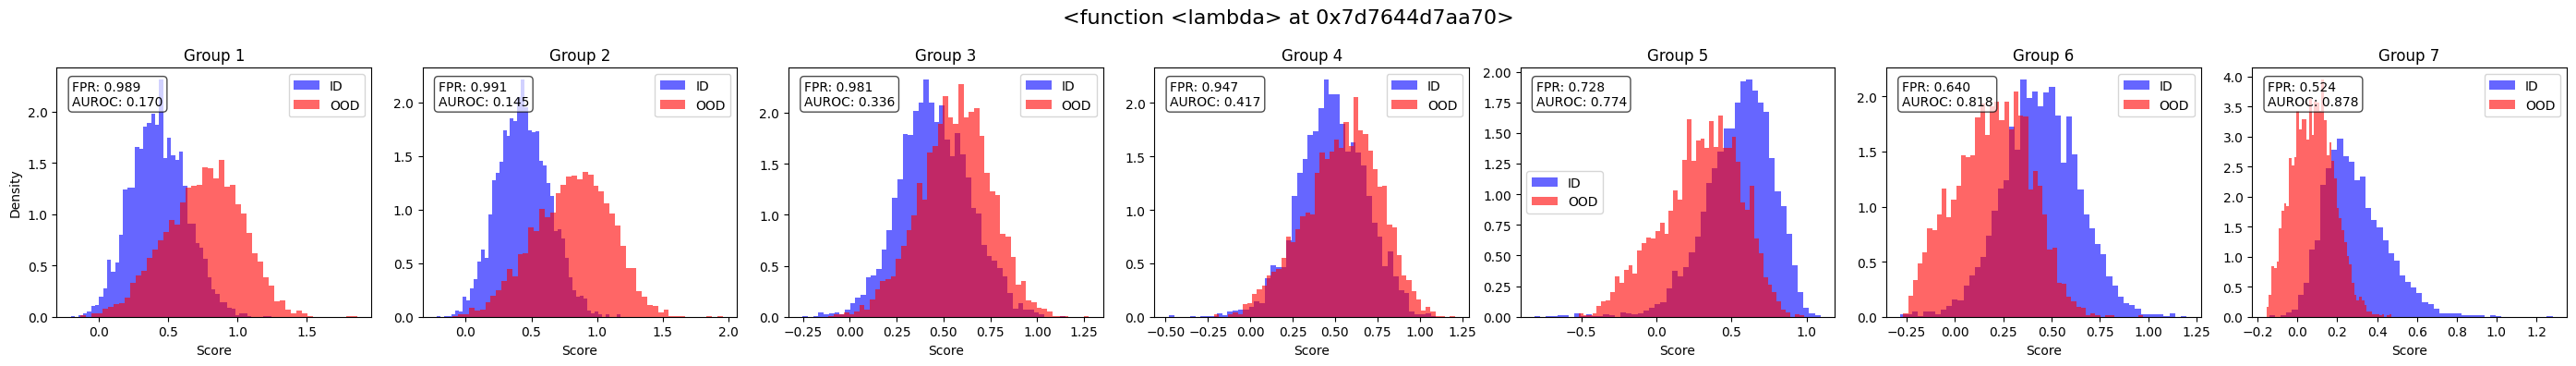

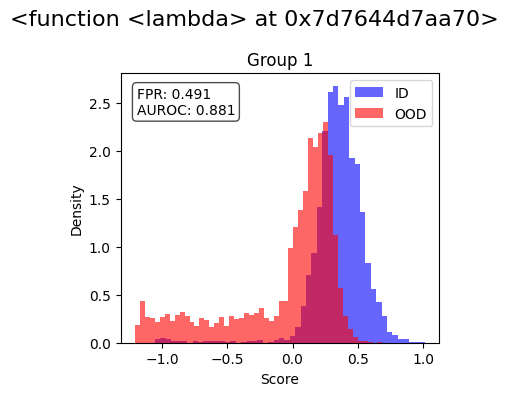

In [13]:
i=1
print(methods[i])
id_norms_all=get_all_activation_strength(model, id_test_loader,methods[i],"react" ,"odin", accelerator, n_iter, config)
ood_norms_all=get_all_activation_strength(model, ood_loader,methods[i],"react" ,"odin", accelerator, n_iter, config)
scores_in_all_standard=compute_standard_score(id_norms_all, QS[i], QE[i]-QS[i])
scores_out_all_standard=compute_standard_score(ood_norms_all,  QS[i], QE[i]-QS[i])
plot_histograms(np.copy(scores_in_all_standard), np.copy(scores_out_all_standard), bins=50, title=str(methods[i]))
scores_main_out=scores_out_all_standard[[5,6],:]
scores_other_out=scores_out_all_standard[[0,1,2,3,4],:]
scores_main_in=scores_in_all_standard[[5,6],:]
scores_other_in=scores_in_all_standard[[0,1,2,3,4],:]
a,delta_score_in=fuse_norm(scores_main_in,scores_other_in)
b,delta_score_out=fuse_norm(scores_main_out,scores_other_out)
plot_histograms(a,b, bins=50, title=str(methods[i]))

<h1 style="color:green; text-shadow: 0 0 10px #ff00ff, 0 0 10px #ff00ff">
  OOD Dataset3: SUN
</h1>

[Test] Loading OOD Dataloader for SUN...
/home/sunshine8641/Code/Data/SUN
cuda
ID Train Batch: x.shape=torch.Size([32, 3, 224, 224])
图像已保存到: Figs/x.png


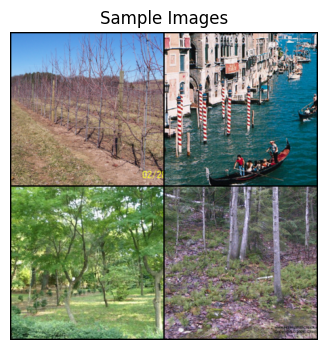

In [15]:
cfg["ood_dataset"]["name"]="SUN"
accelerator,model,criterion,train_meters,test_meters,top_k,id_train_loader,id_test_loader,id_val_loader,ood_loader=initialize_experiment(config)
for batch in ood_loader:
    x, y = batch
    print(f"ID Train Batch: x.shape={x.shape}")
    break
show_images(x, y,mean,std, n=4)

<function l2norm at 0x7d763a76f490>


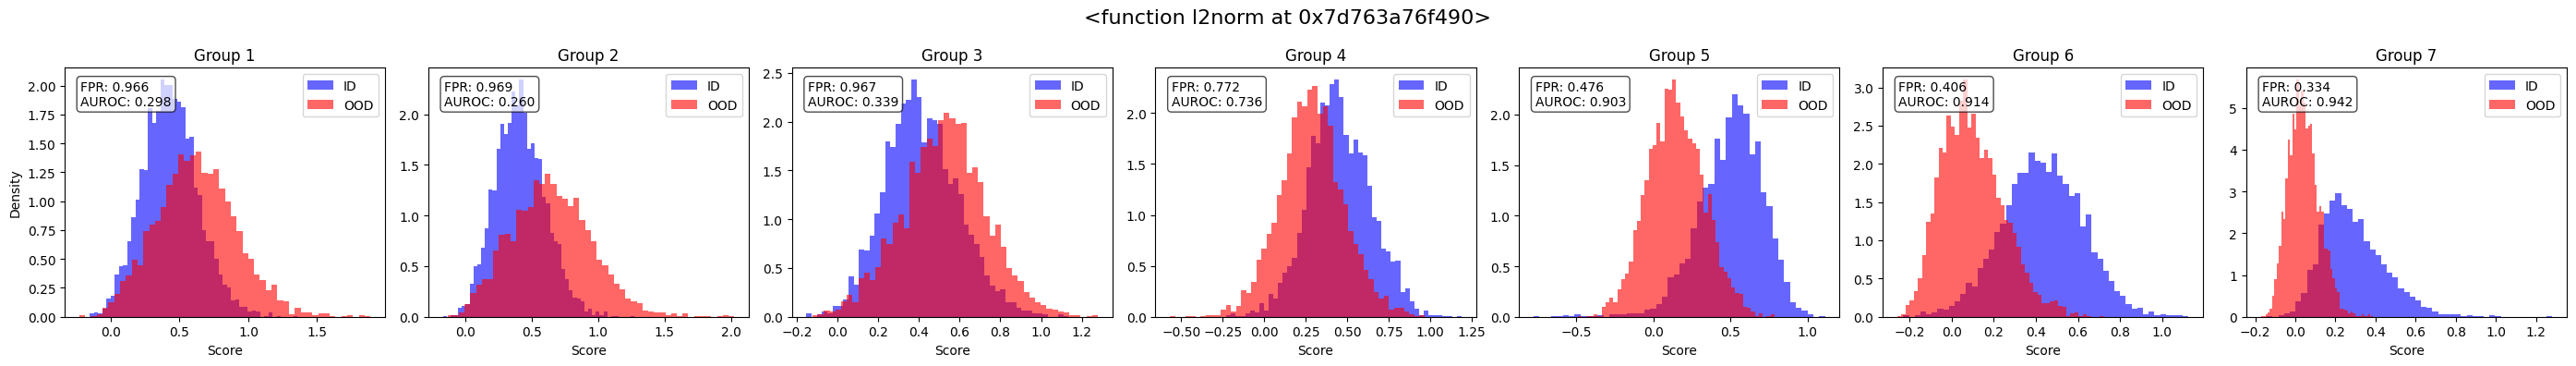

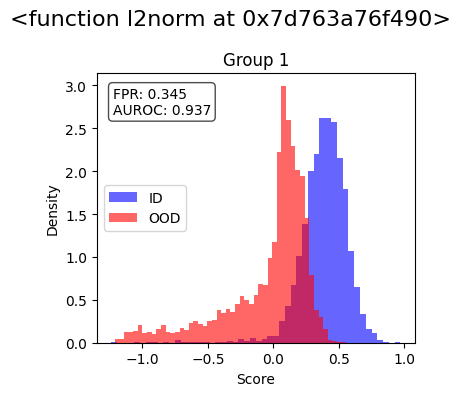

In [16]:
i=0
print(methods[i])
id_norms_all=get_all_activation_strength(model, id_test_loader,methods[i],"react" ,"odin", accelerator, n_iter, config)
ood_norms_all=get_all_activation_strength(model, ood_loader,methods[i],"react" ,"odin", accelerator, n_iter, config)
scores_in_all_standard=compute_standard_score(id_norms_all, QS[i], QE[i]-QS[i])
scores_out_all_standard=compute_standard_score(ood_norms_all,  QS[i], QE[i]-QS[i])
plot_histograms(np.copy(scores_in_all_standard), np.copy(scores_out_all_standard), bins=50, title=str(methods[i]))
scores_main_out=scores_out_all_standard[[5,6],:]
scores_other_out=scores_out_all_standard[[0,1,2,3,4],:]
scores_main_in=scores_in_all_standard[[5,6],:]
scores_other_in=scores_in_all_standard[[0,1,2,3,4],:]
a,delta_score_in=fuse_norm(scores_main_in,scores_other_in)
b,delta_score_out=fuse_norm(scores_main_out,scores_other_out)
plot_histograms(a,b, bins=50, title=str(methods[i]))


<function <lambda> at 0x7d7644d7aa70>


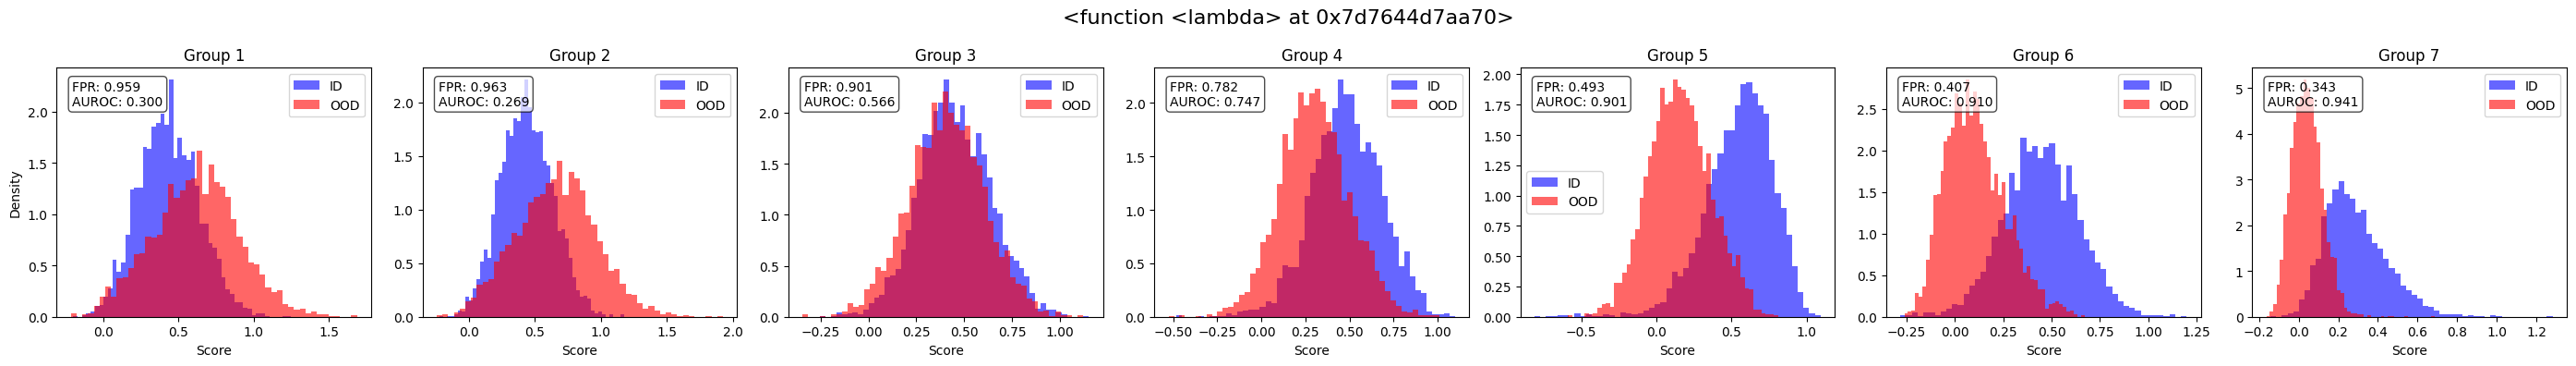

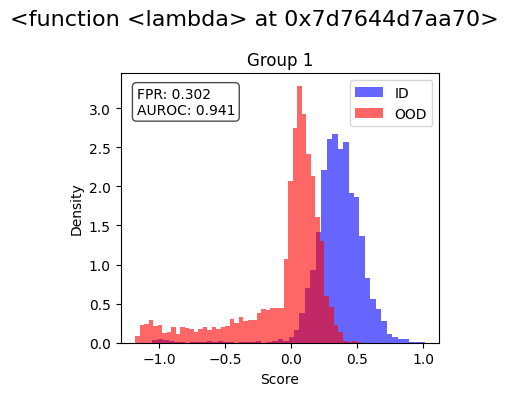

In [17]:
i=1
print(methods[i])
id_norms_all=get_all_activation_strength(model, id_test_loader,methods[i],"react" ,"odin", accelerator, n_iter, config)
ood_norms_all=get_all_activation_strength(model, ood_loader,methods[i],"react" ,"odin", accelerator, n_iter, config)
scores_in_all_standard=compute_standard_score(id_norms_all, QS[i], QE[i]-QS[i])
scores_out_all_standard=compute_standard_score(ood_norms_all,  QS[i], QE[i]-QS[i])
plot_histograms(np.copy(scores_in_all_standard), np.copy(scores_out_all_standard), bins=50, title=str(methods[i]))
scores_main_out=scores_out_all_standard[[5,6],:]
scores_other_out=scores_out_all_standard[[0,1,2,3,4],:]
scores_main_in=scores_in_all_standard[[5,6],:]
scores_other_in=scores_in_all_standard[[0,1,2,3,4],:]
a,delta_score_in=fuse_norm(scores_main_in,scores_other_in)
b,delta_score_out=fuse_norm(scores_main_out,scores_other_out)
plot_histograms(a,b, bins=50, title=str(methods[i]))


<h1 style="color:green; text-shadow: 0 0 10px #ff00ff, 0 0 10px #ff00ff">
  OOD Dataset4: PLACES
</h1>

[Test] Loading OOD Dataloader for Places...
/home/sunshine8641/Code/Data/Places
cuda
ID Train Batch: x.shape=torch.Size([32, 3, 224, 224])
图像已保存到: Figs/x.png


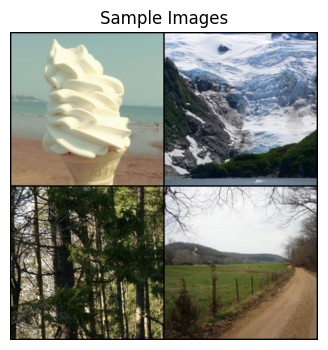

In [18]:
cfg["ood_dataset"]["name"]="Places"
accelerator,model,criterion,train_meters,test_meters,top_k,id_train_loader,id_test_loader,id_val_loader,ood_loader=initialize_experiment(config)
for batch in ood_loader:
    x, y = batch
    print(f"ID Train Batch: x.shape={x.shape}")
    break
show_images(x, y,mean,std, n=4)

<function l2norm at 0x7d763a76f490>


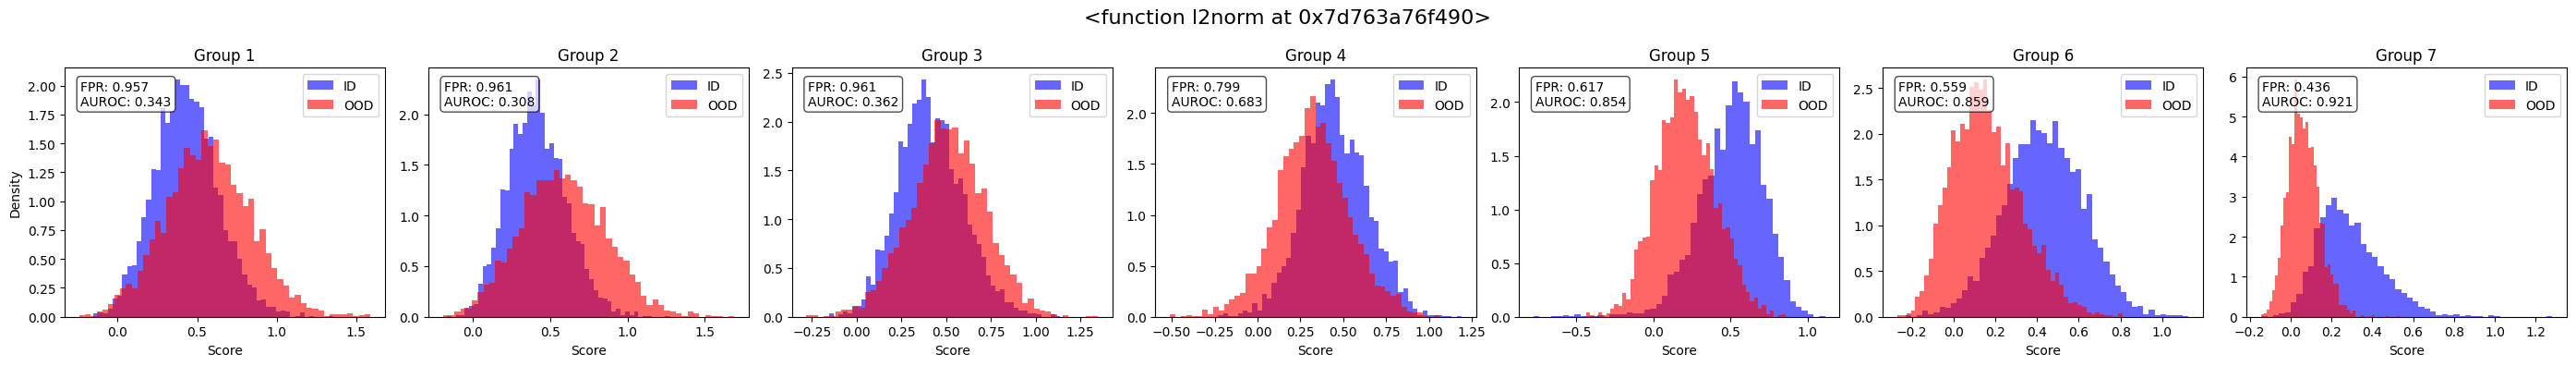

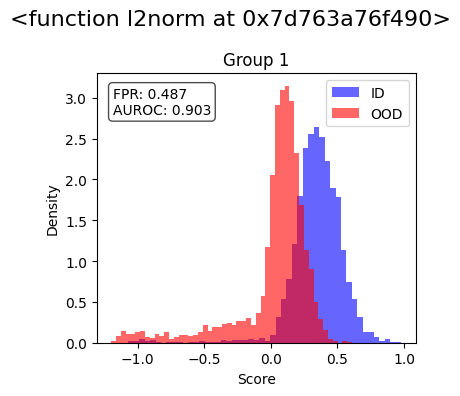

In [19]:
i=0
print(methods[i])
id_norms_all=get_all_activation_strength(model, id_test_loader,methods[i],"react" ,"odin", accelerator, n_iter, config)
ood_norms_all=get_all_activation_strength(model, ood_loader,methods[i],"react" ,"odin", accelerator, n_iter, config)
scores_in_all_standard=compute_standard_score(id_norms_all, QS[i], QE[i]-QS[i])
scores_out_all_standard=compute_standard_score(ood_norms_all,  QS[i], QE[i]-QS[i])
plot_histograms(np.copy(scores_in_all_standard), np.copy(scores_out_all_standard), bins=50, title=str(methods[i]))
scores_main_out=scores_out_all_standard[[5,6],:]
scores_other_out=scores_out_all_standard[[0,1,2,3,4],:]
scores_main_in=scores_in_all_standard[[5,6],:]
scores_other_in=scores_in_all_standard[[0,1,2,3,4],:]
a,delta_score_in=fuse_norm(scores_main_in,scores_other_in)
b,delta_score_out=fuse_norm(scores_main_out,scores_other_out)
plot_histograms(a,b, bins=50, title=str(methods[i]))


<function <lambda> at 0x7d7644d7aa70>


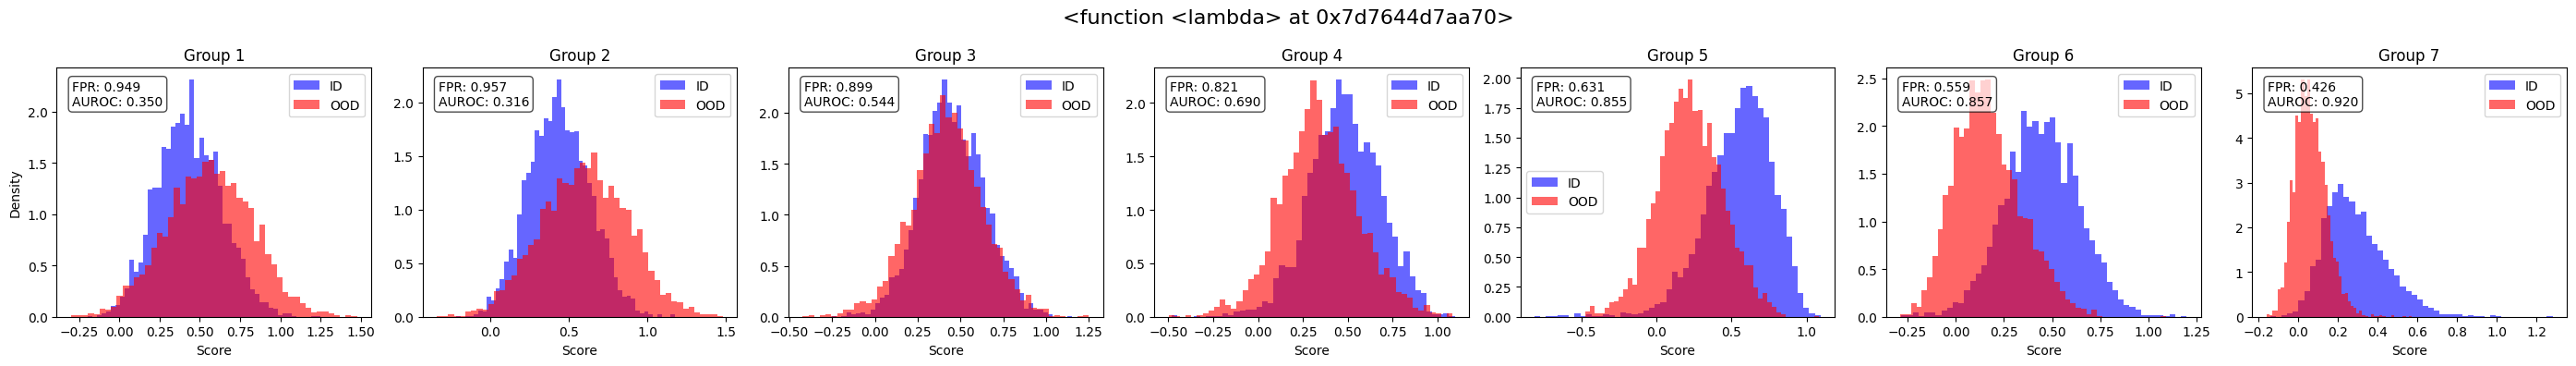

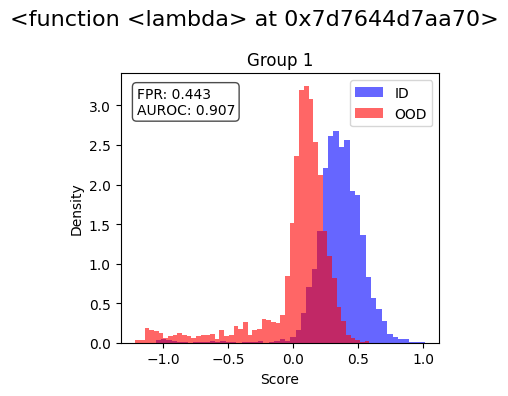

In [20]:
i=1
print(methods[i])
id_norms_all=get_all_activation_strength(model, id_test_loader,methods[i],"react" ,"odin", accelerator, n_iter, config)
ood_norms_all=get_all_activation_strength(model, ood_loader,methods[i],"react" ,"odin", accelerator, n_iter, config)
scores_in_all_standard=compute_standard_score(id_norms_all, QS[i], QE[i]-QS[i])
scores_out_all_standard=compute_standard_score(ood_norms_all,  QS[i], QE[i]-QS[i])
plot_histograms(np.copy(scores_in_all_standard), np.copy(scores_out_all_standard), bins=50, title=str(methods[i]))
scores_main_out=scores_out_all_standard[[5,6],:]
scores_other_out=scores_out_all_standard[[0,1,2,3,4],:]
scores_main_in=scores_in_all_standard[[5,6],:]
scores_other_in=scores_in_all_standard[[0,1,2,3,4],:]
a,delta_score_in=fuse_norm(scores_main_in,scores_other_in)
b,delta_score_out=fuse_norm(scores_main_out,scores_other_out)
plot_histograms(a,b, bins=50, title=str(methods[i]))